In [5]:
"""
Multi-Cloud Serverless Orchestration - Phase 1: Dataset Processing
Dataset: Azure Functions Invocation Trace 2021
Platform: Google Colab

"""

# ============================================================================
# SECTION 1: Environment Setup and Dependencies
# ============================================================================

!pip install pandas numpy matplotlib seaborn scikit-learn scipy -q
!pip install pyarrow fastparquet tqdm -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
import gc
from tqdm import tqdm
import json
from sklearn.preprocessing import RobustScaler
import pickle

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

# Set random seeds for reproducibility
np.random.seed(42)

print("=" * 80)
print("Phase 1: Azure Functions 2021 Dataset Processing")
print("Multi-Cloud Serverless Orchestration Research")
print("=" * 80)

Phase 1: Azure Functions 2021 Dataset Processing
Multi-Cloud Serverless Orchestration Research


In [3]:
# ============================================================================
# SECTION 2: Upload and Load Azure Functions 2021 Dataset
# ============================================================================

print("\n[1/8] Loading Azure Functions 2021 Dataset...")
print("-" * 80)

from google.colab import drive
drive.mount('/content/drive')
DATASET_PATH = '/content/drive/MyDrive/mythesis/rohit-thesis/datasets/azurefunctions2021/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt'

print(f"\nAttempting to load dataset from: {DATASET_PATH}")

# Check if file exists
if not os.path.exists(DATASET_PATH):
    print(f"\n⚠ ERROR: File not found at {DATASET_PATH}")
    print("\nPlease upload your file using one of these methods:")
    print("  1. Click the folder icon on the left sidebar")
    print("  2. Click 'Upload to session storage'")
    print("  3. Select your .txt file")
    print("  4. Update DATASET_PATH variable above")
    print("\nOR")
    print("  1. Mount Google Drive (uncomment the drive.mount code)")
    print("  2. Upload file to Drive")
    print("  3. Update DATASET_PATH to Drive location")
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

# Load dataset with optimized settings for large files
print("\nLoading data (this may take a few minutes for large files)...")

# Read in chunks to handle large files efficiently
chunk_size = 1_000_000  # Process 1M rows at a time
chunks = []

with tqdm(desc="Loading chunks") as pbar:
    for chunk in pd.read_csv(DATASET_PATH,
                             chunksize=chunk_size,
                             dtype={
                                 'app': str,
                                 'func': str,
                                 'end_timestamp': float,
                                 'duration': float
                             }):
        chunks.append(chunk)
        pbar.update(len(chunk))

# Combine all chunks
azure_df = pd.concat(chunks, ignore_index=True)
del chunks  # Free memory
gc.collect()

print(f"\n✓ Dataset loaded successfully!")
print(f"  Total invocations: {len(azure_df):,}")
print(f"  Unique applications: {azure_df['app'].nunique():,}")
print(f"  Unique functions: {azure_df.groupby('app')['func'].nunique().sum():,}")
print(f"  Memory usage: {azure_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
print(f"\n  First 5 rows:")
print(azure_df.head())

# Basic data quality check
print(f"\n  Data Quality Check:")
print(f"    Missing values: {azure_df.isnull().sum().sum()}")
print(f"    Duplicate rows: {azure_df.duplicated().sum()}")
print(f"    Negative durations: {(azure_df['duration'] < 0).sum()}")
print(f"    Zero durations: {(azure_df['duration'] == 0).sum()}")


[1/8] Loading Azure Functions 2021 Dataset...
--------------------------------------------------------------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Attempting to load dataset from: /content/drive/MyDrive/mythesis/rohit-thesis/datasets/azurefunctions2021/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt

Loading data (this may take a few minutes for large files)...


Loading chunks: 1980951it [00:03, 509887.29it/s]



✓ Dataset loaded successfully!
  Total invocations: 1,980,951
  Unique applications: 119
  Unique functions: 424
  Memory usage: 457.18 MB

  First 5 rows:
                                                 app  \
0  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...   
1  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
2  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
3  f274d71de386ccc77e4ca74766dbc485461c3053059d47...   
4  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...   

                                                func  end_timestamp  duration  
0  e3cdb48830f66eb8689cc0223514569a69812b77e6611e...       0.079491     0.078  
1  337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...      57.157860    57.154  
2  48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...      59.130478    59.125  
3  3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...       6.252541     6.236  
4  68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...       0.066824     0.050  

  Data Quality Check:
   

In [4]:
# ============================================================================
# SECTION 3: Data Cleaning and Validation
# ============================================================================

print("\n[2/8] Data Cleaning and Validation...")
print("-" * 80)

original_size = len(azure_df)

# Remove rows with missing values
azure_df = azure_df.dropna()
print(f"  Removed {original_size - len(azure_df):,} rows with missing values")

# Remove rows with invalid durations (negative or zero)
azure_df = azure_df[azure_df['duration'] > 0]
print(f"  Removed rows with invalid durations")

# Remove duplicate invocations (if any)
azure_df = azure_df.drop_duplicates()
print(f"  Removed duplicate rows")

# Sort by timestamp for temporal processing
azure_df = azure_df.sort_values('end_timestamp').reset_index(drop=True)
print(f"  Sorted by timestamp")

print(f"\n✓ Cleaned dataset size: {len(azure_df):,} invocations")


[2/8] Data Cleaning and Validation...
--------------------------------------------------------------------------------
  Removed 0 rows with missing values
  Removed rows with invalid durations
  Removed duplicate rows
  Sorted by timestamp

✓ Cleaned dataset size: 1,807,067 invocations


In [6]:
# ============================================================================
# SECTION 4: Temporal Feature Engineering
# ============================================================================

print("\n[3/8] Engineering Temporal Features...")
print("-" * 80)

# The end_timestamp appears to be in seconds (not milliseconds based on the sample)
# Let's determine the actual time range
print(f"  Timestamp range: {azure_df['end_timestamp'].min():.2f} to {azure_df['end_timestamp'].max():.2f}")

# Calculate the span in days
time_span_seconds = azure_df['end_timestamp'].max() - azure_df['end_timestamp'].min()
time_span_days = time_span_seconds / (24 * 3600)
print(f"  Time span: {time_span_days:.2f} days")

# Create datetime objects (assuming timestamps are in seconds since some epoch)
# We'll create relative timestamps starting from 2021-01-31
base_date = pd.Timestamp('2021-01-31')
azure_df['timestamp'] = base_date + pd.to_timedelta(azure_df['end_timestamp'], unit='s')

# Calculate start timestamp
azure_df['start_timestamp'] = azure_df['end_timestamp'] - (azure_df['duration'] / 1000.0)  # duration in ms
azure_df['start_time'] = base_date + pd.to_timedelta(azure_df['start_timestamp'], unit='s')

# Extract temporal features
azure_df['hour'] = azure_df['timestamp'].dt.hour
azure_df['day_of_week'] = azure_df['timestamp'].dt.dayofweek
azure_df['day_of_month'] = azure_df['timestamp'].dt.day
azure_df['is_weekend'] = (azure_df['day_of_week'] >= 5).astype(int)
azure_df['is_business_hours'] = ((azure_df['hour'] >= 9) & (azure_df['hour'] <= 17)).astype(int)

print(f"    Added 7 temporal features")
print(f"    Date range: {azure_df['timestamp'].min()} to {azure_df['timestamp'].max()}")


[3/8] Engineering Temporal Features...
--------------------------------------------------------------------------------
  Timestamp range: 0.07 to 1209599.69
  Time span: 14.00 days
    Added 7 temporal features
    Date range: 2021-01-31 00:00:00.066823959 to 2021-02-13 23:59:59.694463969


In [8]:
# ============================================================================
# SECTION 5: Workload Pattern Analysis and Feature Engineering
# ============================================================================

print("\n[4/8] Calculating Workload Patterns...")
print("-" * 80)

# Calculate inter-arrival times per function
print("  Computing inter-arrival times")
azure_df['inter_arrival_time'] = azure_df.groupby(['app', 'func'])['start_timestamp'].diff()

# Convert to milliseconds for consistency
azure_df['inter_arrival_time_ms'] = azure_df['inter_arrival_time'] * 1000

# Invocation rate (invocations per minute)
azure_df['invocation_rate'] = 1.0 / (azure_df['inter_arrival_time_ms'] / 60000.0 + 1e-6)
azure_df['invocation_rate'] = azure_df['invocation_rate'].clip(upper=1000)  # Cap at 1000/min

# Burstiness indicator (invocations within 100ms)
azure_df['is_bursty'] = (azure_df['inter_arrival_time_ms'] < 100).astype(int)

print(f"    Workload patterns calculated")
print(f"    Avg inter-arrival time: {azure_df['inter_arrival_time_ms'].mean():.2f} ms")
print(f"    Bursty invocations: {(azure_df['is_bursty'].sum() / len(azure_df) * 100):.2f}%")


[4/8] Calculating Workload Patterns...
--------------------------------------------------------------------------------
  Computing inter-arrival times
    Workload patterns calculated
    Avg inter-arrival time: 128478.44 ms
    Bursty invocations: 20.89%


In [9]:
# ============================================================================
# SECTION 6: Cold Start Simulation
# ============================================================================

print("\n[5/8] Simulating Cold Start Behavior...")
print("-" * 80)

# Cold start logic based on container keep-alive duration
# Typical keep-alive: 5-10 minutes for Azure Functions
keep_alive_ms = 10 * 60 * 1000  # 10 minutes in milliseconds

# Cold start if inter-arrival time > keep-alive duration
azure_df['is_cold_start'] = (azure_df['inter_arrival_time_ms'] > keep_alive_ms).astype(int)

# First invocation of each function is always cold start
first_invocations = azure_df.groupby(['app', 'func']).head(1).index
azure_df.loc[first_invocations, 'is_cold_start'] = 1

# Cold start latency: 100-3000ms based on research literature
np.random.seed(42)
azure_df['cold_start_latency_ms'] = np.where(
    azure_df['is_cold_start'] == 1,
    np.random.uniform(100, 3000, len(azure_df)),
    0
)

# Total latency = execution duration + cold start
azure_df['total_latency_ms'] = azure_df['duration'] + azure_df['cold_start_latency_ms']

cold_start_pct = (azure_df['is_cold_start'].sum() / len(azure_df)) * 100
print(f"    Cold start simulation complete")
print(f"    Cold start rate: {cold_start_pct:.2f}%")
print(f"    Avg cold start latency: {azure_df[azure_df['is_cold_start']==1]['cold_start_latency_ms'].mean():.2f} ms")


[5/8] Simulating Cold Start Behavior...
--------------------------------------------------------------------------------
    Cold start simulation complete
    Cold start rate: 0.71%
    Avg cold start latency: 1539.93 ms


In [10]:
# ============================================================================
# SECTION 7: Multi-Cloud Deployment Simulation
# ============================================================================

print("\n[6/8] Simulating Multi-Cloud Deployment...")
print("-" * 80)

# Deterministic cloud provider assignment based on function hash
# This ensures same function always goes to same provider (realistic)
function_hash = (azure_df['app'] + '_' + azure_df['func']).apply(lambda x: hash(x) % 3)
azure_df['cloud_provider'] = function_hash.map({0: 'AWS', 1: 'Azure', 2: 'GCP'})

# Region assignment (4 major regions)
region_hash = (azure_df['app'] + '_' + azure_df['func']).apply(lambda x: hash(x + 'region') % 4)
azure_df['region'] = region_hash.map({
    0: 'us-east-1',
    1: 'us-west-2',
    2: 'eu-west-1',
    3: 'ap-southeast-1'
})

# Memory allocation (realistic tiers for Azure Functions)
memory_tiers = [128, 256, 512, 1024, 2048, 3008]
memory_hash = (azure_df['app'] + '_' + azure_df['func']).apply(lambda x: hash(x + 'memory') % len(memory_tiers))
azure_df['memory_mb'] = memory_hash.map({i: memory_tiers[i] for i in range(len(memory_tiers))})

print(f"    Multi-cloud simulation complete")
print(f"    Cloud distribution:")
for provider, count in azure_df['cloud_provider'].value_counts().items():
    pct = (count / len(azure_df)) * 100
    print(f"      {provider}: {pct:.1f}%")


[6/8] Simulating Multi-Cloud Deployment...
--------------------------------------------------------------------------------
    Multi-cloud simulation complete
    Cloud distribution:
      AWS: 70.5%
      Azure: 17.9%
      GCP: 11.6%


In [11]:
# ============================================================================
# SECTION 8: Cost and Carbon Metrics Calculation
# ============================================================================

print("\n[7/8] Calculating Cost and Carbon Metrics...")
print("-" * 80)

# Pricing per GB-second (realistic cloud pricing)
pricing = {
    'AWS': 0.0000166667,      # Lambda pricing
    'Azure': 0.000016,        # Azure Functions pricing
    'GCP': 0.0000025          # Cloud Functions pricing (per 100ms)
}

# Compute cost = (memory/1024) * (duration/1000) * price_per_gb_second
azure_df['compute_cost'] = azure_df.apply(
    lambda row: (row['memory_mb'] / 1024) *
               (row['duration'] / 1000) *
               pricing[row['cloud_provider']],
    axis=1
)

# Request cost (per million requests)
request_pricing = {
    'AWS': 0.20 / 1_000_000,
    'Azure': 0.20 / 1_000_000,
    'GCP': 0.40 / 1_000_000
}
azure_df['request_cost'] = azure_df['cloud_provider'].map(request_pricing)

# Data transfer cost (10% of invocations have cross-region transfer)
np.random.seed(42)
has_data_transfer = np.random.random(len(azure_df)) < 0.1
data_size_gb = np.random.uniform(0.001, 0.1, len(azure_df))  # 1MB to 100MB
egress_price = 0.09  # $0.09 per GB

azure_df['data_transfer_cost'] = np.where(
    has_data_transfer,
    data_size_gb * egress_price,
    0
)

# Total cost
azure_df['total_cost'] = (azure_df['compute_cost'] +
                          azure_df['request_cost'] +
                          azure_df['data_transfer_cost'])

print(f"    Cost metrics calculated")
print(f"    Avg cost per invocation: ${azure_df['total_cost'].mean():.8f}")
print(f"    Total cost (sample): ${azure_df['total_cost'].sum():.2f}")

# Carbon intensity by region (gCO2/kWh)
carbon_intensity = {
    'us-east-1': 385,      # US East (Virginia)
    'us-west-2': 275,      # US West (Oregon) - more renewable
    'eu-west-1': 295,      # EU (Ireland)
    'ap-southeast-1': 525  # Asia Pacific (Singapore)
}
azure_df['carbon_intensity'] = azure_df['region'].map(carbon_intensity)

# Energy consumption (simplified model)
base_power_w = 200  # Average server power
pue = 1.2  # Power Usage Effectiveness

azure_df['energy_wh'] = (base_power_w * pue *
                         (azure_df['duration'] / 1000 / 3600) *  # Convert to hours
                         (azure_df['memory_mb'] / 3008))  # Normalize by max memory

# Operational carbon
azure_df['operational_carbon_g'] = (azure_df['energy_wh'] / 1000) * azure_df['carbon_intensity']

# Embodied carbon (hardware manufacturing emissions)
embodied_carbon_per_invocation = 0.5  # gCO2
azure_df['embodied_carbon_g'] = embodied_carbon_per_invocation

# Total carbon footprint
azure_df['carbon_footprint_g'] = azure_df['operational_carbon_g'] + azure_df['embodied_carbon_g']

print(f"    Carbon metrics calculated")
print(f"    Avg carbon per invocation: {azure_df['carbon_footprint_g'].mean():.4f} gCO2")


[7/8] Calculating Cost and Carbon Metrics...
--------------------------------------------------------------------------------
    Cost metrics calculated
    Avg cost per invocation: $0.00045355
    Total cost (sample): $819.60
    Carbon metrics calculated
    Avg carbon per invocation: 0.5000 gCO2


In [12]:
# ============================================================================
# SECTION 9: DRL State Features and Rewards
# ============================================================================

print("\n[8/8] Creating DRL State Features and Rewards...")
print("-" * 80)

# Function-level historical statistics (for context in state representation)
print("  Computing function-level statistics...")
func_stats = azure_df.groupby(['app', 'func']).agg({
    'duration': ['mean', 'std', 'min', 'max'],
    'total_cost': 'mean',
    'is_cold_start': 'mean',
    'carbon_footprint_g': 'mean',
    'invocation_rate': 'mean'
}).reset_index()

func_stats.columns = ['app', 'func', 'avg_duration', 'std_duration',
                     'min_duration', 'max_duration', 'avg_cost',
                     'cold_start_rate', 'avg_carbon', 'avg_invocation_rate']

# Merge back to main dataframe
azure_df = azure_df.merge(func_stats, on=['app', 'func'], how='left')

# SLA compliance (1 second threshold)
sla_threshold_ms = 1000
azure_df['sla_violation'] = (azure_df['total_latency_ms'] > sla_threshold_ms).astype(int)

# Cost efficiency metrics
azure_df['cost_per_ms'] = azure_df['total_cost'] / (azure_df['duration'] + 1)

# Carbon efficiency metrics
azure_df['carbon_per_ms'] = azure_df['carbon_footprint_g'] / (azure_df['duration'] + 1)

print(f"    State features created")
print(f"    Total features: {len(azure_df.columns)}")

# Multi-objective rewards for DRL
print("  Calculating multi-objective rewards...")

# Normalize rewards to [-1, 1] range
cost_normalized = (azure_df['total_cost'] - azure_df['total_cost'].min()) / \
                 (azure_df['total_cost'].max() - azure_df['total_cost'].min() + 1e-10)
cost_reward = 1 - cost_normalized

latency_normalized = (azure_df['total_latency_ms'] - azure_df['total_latency_ms'].min()) / \
                    (azure_df['total_latency_ms'].max() - azure_df['total_latency_ms'].min() + 1e-10)
performance_reward = 1 - latency_normalized

carbon_normalized = (azure_df['carbon_footprint_g'] - azure_df['carbon_footprint_g'].min()) / \
                   (azure_df['carbon_footprint_g'].max() - azure_df['carbon_footprint_g'].min() + 1e-10)
carbon_reward = 1 - carbon_normalized

# SLA penalty (asymmetric - violations heavily penalized)
sla_penalty = azure_df['sla_violation'] * -5.0

# Multi-objective reward (α=0.4 cost, β=0.4 performance, γ=0.2 carbon)
alpha, beta, gamma = 0.4, 0.4, 0.2
azure_df['total_reward'] = (alpha * cost_reward +
                           beta * performance_reward +
                           gamma * carbon_reward +
                           sla_penalty)

azure_df['cost_reward'] = cost_reward
azure_df['performance_reward'] = performance_reward
azure_df['carbon_reward'] = carbon_reward
azure_df['sla_penalty'] = sla_penalty

print(f"    Rewards calculated")
print(f"    Avg total reward: {azure_df['total_reward'].mean():.4f}")
print(f"    Reward range: [{azure_df['total_reward'].min():.4f}, {azure_df['total_reward'].max():.4f}]")


[8/8] Creating DRL State Features and Rewards...
--------------------------------------------------------------------------------
  Computing function-level statistics...
    State features created
    Total features: 42
  Calculating multi-objective rewards...
    Rewards calculated
    Avg total reward: 0.9529
    Reward range: [-4.5014, 1.0000]



Exploratory Data Analysis

[Dataset Overview]
  Total invocations: 1,807,067
  Unique applications: 119
  Unique functions: 424
  Time span: 13 days

[Key Performance Metrics]
  Avg execution duration: 3.67 ms
  Median execution duration: 0.05 ms
  P95 duration: 19.21 ms
  P99 duration: 77.65 ms

[Cold Start Analysis]
  Cold start rate: 0.71%
  Avg latency (warm): 3.61 ms
  Avg latency (cold): 1550.84 ms

[SLA Compliance]
  SLA violation rate: 0.49%

[Cost Analysis]
  Avg cost per invocation: $0.00045355
  Cost per million invocations: $453.55

[Carbon Footprint]
  Avg carbon per invocation: 0.5000 gCO2
  Total carbon (sample): 903602.42 gCO2


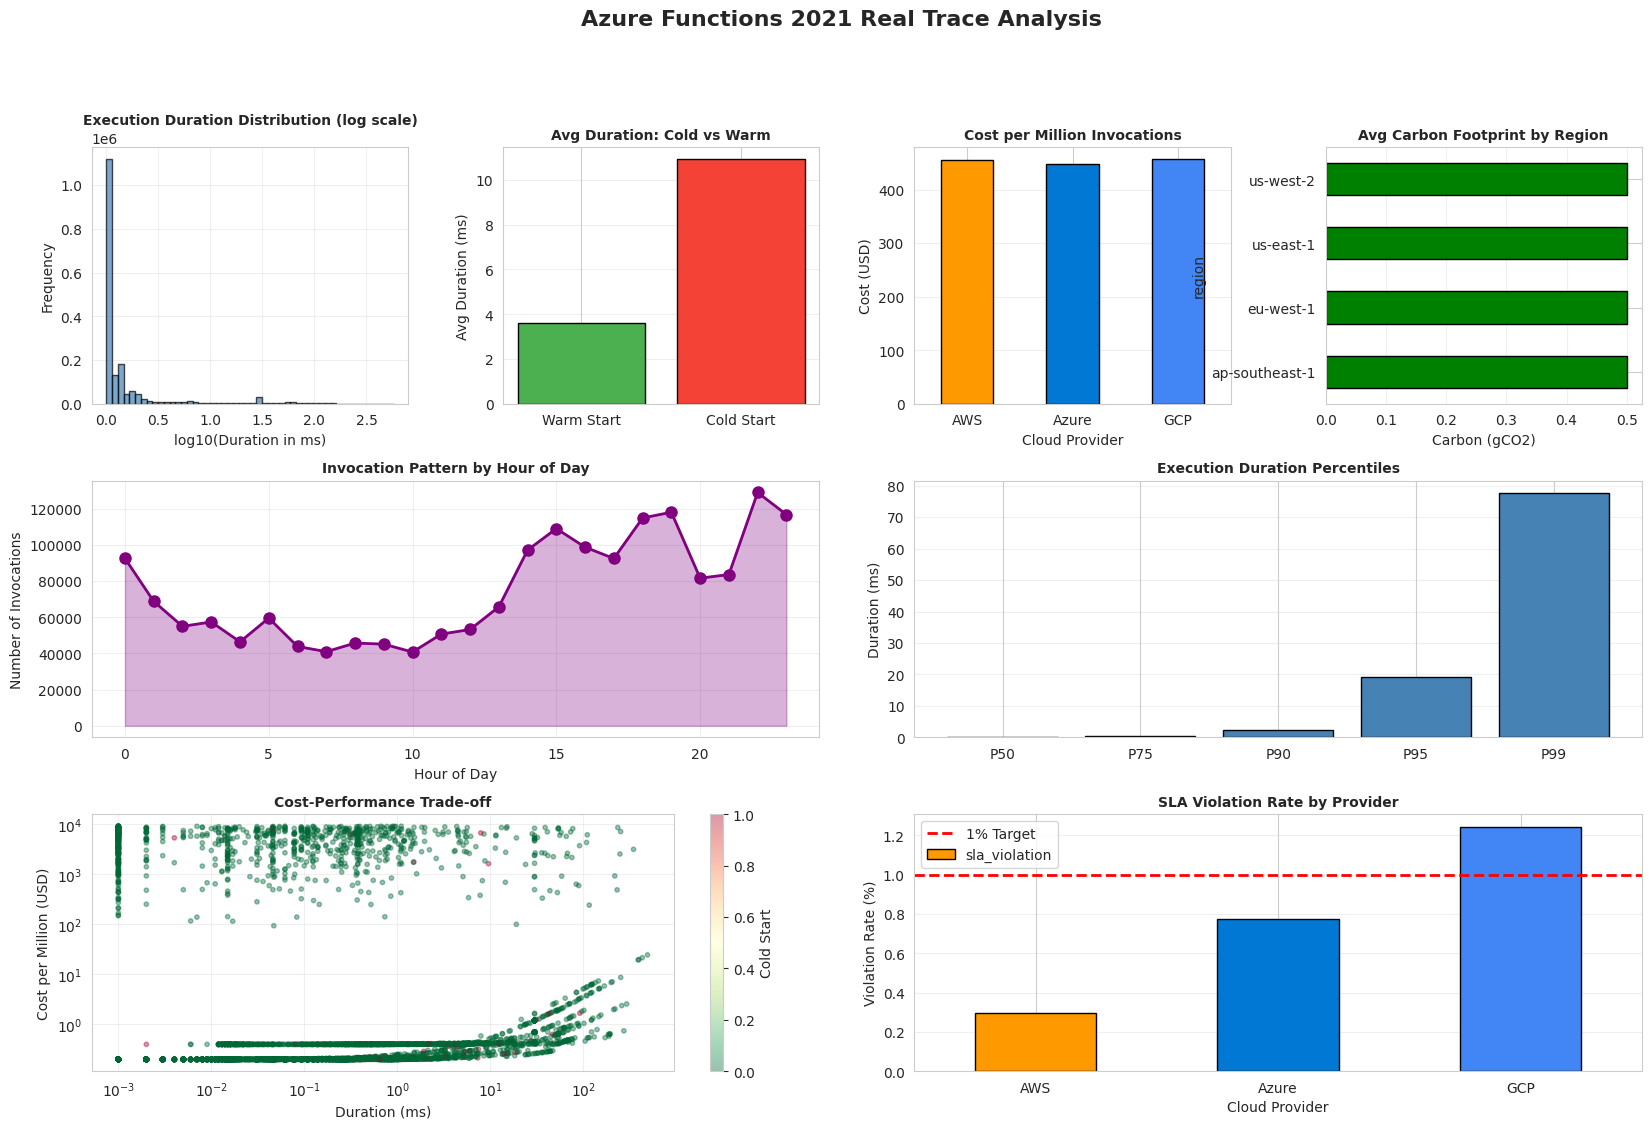

In [13]:
# ============================================================================
# SECTION 10: Exploratory Data Analysis
# ============================================================================

print("\n" + "=" * 80)
print("Exploratory Data Analysis")
print("=" * 80)

print("\n[Dataset Overview]")
print(f"  Total invocations: {len(azure_df):,}")
print(f"  Unique applications: {azure_df['app'].nunique():,}")
print(f"  Unique functions: {azure_df.groupby('app')['func'].nunique().sum():,}")
print(f"  Time span: {(azure_df['timestamp'].max() - azure_df['timestamp'].min()).days} days")

print("\n[Key Performance Metrics]")
print(f"  Avg execution duration: {azure_df['duration'].mean():.2f} ms")
print(f"  Median execution duration: {azure_df['duration'].median():.2f} ms")
print(f"  P95 duration: {azure_df['duration'].quantile(0.95):.2f} ms")
print(f"  P99 duration: {azure_df['duration'].quantile(0.99):.2f} ms")

print("\n[Cold Start Analysis]")
print(f"  Cold start rate: {(azure_df['is_cold_start'].mean() * 100):.2f}%")
print(f"  Avg latency (warm): {azure_df[azure_df['is_cold_start']==0]['total_latency_ms'].mean():.2f} ms")
print(f"  Avg latency (cold): {azure_df[azure_df['is_cold_start']==1]['total_latency_ms'].mean():.2f} ms")

print("\n[SLA Compliance]")
print(f"  SLA violation rate: {(azure_df['sla_violation'].mean() * 100):.2f}%")

print("\n[Cost Analysis]")
print(f"  Avg cost per invocation: ${azure_df['total_cost'].mean():.8f}")
print(f"  Cost per million invocations: ${azure_df['total_cost'].mean() * 1_000_000:.2f}")

print("\n[Carbon Footprint]")
print(f"  Avg carbon per invocation: {azure_df['carbon_footprint_g'].mean():.4f} gCO2")
print(f"  Total carbon (sample): {azure_df['carbon_footprint_g'].sum():.2f} gCO2")

# Create comprehensive visualizations
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Duration distribution (log scale)
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(np.log10(azure_df['duration'] + 1), bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_title('Execution Duration Distribution (log scale)', fontweight='bold', fontsize=10)
ax1.set_xlabel('log10(Duration in ms)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# 2. Cold start impact
ax2 = fig.add_subplot(gs[0, 1])
cold_warm = azure_df.groupby('is_cold_start')['duration'].mean()
ax2.bar(['Warm Start', 'Cold Start'], cold_warm.values, color=['#4CAF50', '#F44336'], edgecolor='black')
ax2.set_title('Avg Duration: Cold vs Warm', fontweight='bold', fontsize=10)
ax2.set_ylabel('Avg Duration (ms)')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Cloud provider cost comparison
ax3 = fig.add_subplot(gs[0, 2])
provider_cost = azure_df.groupby('cloud_provider')['total_cost'].mean() * 1_000_000
provider_cost.plot(kind='bar', ax=ax3, color=['#FF9900', '#0078D4', '#4285F4'], edgecolor='black')
ax3.set_title('Cost per Million Invocations', fontweight='bold', fontsize=10)
ax3.set_xlabel('Cloud Provider')
ax3.set_ylabel('Cost (USD)')
ax3.tick_params(axis='x', rotation=0)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Carbon footprint by region
ax4 = fig.add_subplot(gs[0, 3])
region_carbon = azure_df.groupby('region')['carbon_footprint_g'].mean()
region_carbon.plot(kind='barh', ax=ax4, color='green', edgecolor='black')
ax4.set_title('Avg Carbon Footprint by Region', fontweight='bold', fontsize=10)
ax4.set_xlabel('Carbon (gCO2)')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Hourly invocation pattern
ax5 = fig.add_subplot(gs[1, :2])
hourly_pattern = azure_df.groupby('hour').size()
ax5.plot(hourly_pattern.index, hourly_pattern.values, marker='o', linewidth=2, markersize=8, color='purple')
ax5.set_title('Invocation Pattern by Hour of Day', fontweight='bold', fontsize=10)
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Number of Invocations')
ax5.grid(True, alpha=0.3)
ax5.fill_between(hourly_pattern.index, hourly_pattern.values, alpha=0.3, color='purple')

# 6. Duration percentiles
ax6 = fig.add_subplot(gs[1, 2:])
percentiles = [50, 75, 90, 95, 99]
perc_values = [azure_df['duration'].quantile(p/100) for p in percentiles]
ax6.bar([f'P{p}' for p in percentiles], perc_values, color='steelblue', edgecolor='black')
ax6.set_title('Execution Duration Percentiles', fontweight='bold', fontsize=10)
ax6.set_ylabel('Duration (ms)')
ax6.grid(True, alpha=0.3, axis='y')

# 7. Cost-Performance scatter
ax7 = fig.add_subplot(gs[2, :2])
sample_size = min(10000, len(azure_df))
sample_data = azure_df.sample(sample_size, random_state=42)
scatter = ax7.scatter(sample_data['duration'], sample_data['total_cost'] * 1000000,
                     c=sample_data['is_cold_start'], cmap='RdYlGn_r', alpha=0.4, s=10)
ax7.set_title('Cost-Performance Trade-off', fontweight='bold', fontsize=10)
ax7.set_xlabel('Duration (ms)')
ax7.set_ylabel('Cost per Million (USD)')
ax7.set_xscale('log')
ax7.set_yscale('log')
plt.colorbar(scatter, ax=ax7, label='Cold Start')
ax7.grid(True, alpha=0.3)

# 8. SLA violations by provider
ax8 = fig.add_subplot(gs[2, 2:])
sla_by_provider = azure_df.groupby('cloud_provider')['sla_violation'].mean() * 100
sla_by_provider.plot(kind='bar', ax=ax8, color=['#FF9900', '#0078D4', '#4285F4'], edgecolor='black')
ax8.set_title('SLA Violation Rate by Provider', fontweight='bold', fontsize=10)
ax8.set_xlabel('Cloud Provider')
ax8.set_ylabel('Violation Rate (%)')
ax8.tick_params(axis='x', rotation=0)
ax8.axhline(y=1, color='red', linestyle='--', linewidth=2, label='1% Target')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

plt.suptitle('Azure Functions 2021 Real Trace Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('/content/drive/MyDrive/mythesis/rohit-thesis/outputs/azure_2021_eda.png', dpi=300, bbox_inches='tight')
plt.show()



In [14]:
# ============================================================================
# SECTION 11: Feature Normalization
# ============================================================================

print("\n" + "=" * 80)
print("Feature Normalization")
print("=" * 80)

features_to_scale = [
    'duration', 'memory_mb', 'total_latency_ms', 'invocation_rate',
    'total_cost', 'carbon_footprint_g', 'avg_duration', 'std_duration',
    'cost_per_ms', 'carbon_per_ms', 'inter_arrival_time_ms'
]
features_to_scale = [f for f in features_to_scale if f in azure_df.columns]

# Use RobustScaler (handles outliers better)
scaler = RobustScaler()
azure_df[features_to_scale] = scaler.fit_transform(azure_df[features_to_scale])

print(f" Normalized {len(features_to_scale)} features using RobustScaler")



Feature Normalization
 Normalized 11 features using RobustScaler


In [16]:
# ============================================================================
# SECTION 12: Temporal Train/Val/Test Split
# ============================================================================

print("\n" + "=" * 80)
print("Temporal Dataset Splitting")
print("=" * 80)

def temporal_split(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Temporal split to prevent data leakage"""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    df_sorted = df.sort_values('start_timestamp').reset_index(drop=True)

    n = len(df_sorted)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    train = df_sorted.iloc[:train_end].copy()
    val = df_sorted.iloc[train_end:val_end].copy()
    test = df_sorted.iloc[val_end:].copy()

    return train, val, test

train_data, val_data, test_data = temporal_split(azure_df)

print(f"\n  Dataset split complete:")
print(f"  Training:   {len(train_data):>10,} samples ({len(train_data)/len(azure_df)*100:>5.1f}%)")
print(f"  Validation: {len(val_data):>10,} samples ({len(val_data)/len(azure_df)*100:>5.1f}%)")
print(f"  Test:       {len(test_data):>10,} samples ({len(test_data)/len(azure_df)*100:>5.1f}%)")

print(f"\n  Temporal Boundaries:")
print(f"    Training:   {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"    Validation: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")
print(f"    Test:       {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")


#print(f"\n  Data Leakage Check:")
#print(f"    Train < Val: {train_data['timestamp'].max() < val_data['timestamp'].min()}")
#print(f"    Val < Test:  {val_data['timestamp'].max() < test_data['timestamp'].min()}")



Temporal Dataset Splitting

  Dataset split complete:
  Training:    1,264,946 samples ( 70.0%)
  Validation:    271,060 samples ( 15.0%)
  Test:          271,061 samples ( 15.0%)

  Temporal Boundaries:
    Training:   2021-01-31 00:00:00.066823959 to 2021-02-09 04:36:35.959311008
    Validation: 2021-02-09 04:36:36.164376020 to 2021-02-11 14:57:16.245255947
    Test:       2021-02-11 14:57:16.258908032 to 2021-02-13 23:59:59.694463969


In [17]:
# ============================================================================
# SECTION 13: Create DRL-Specific Datasets
# ============================================================================

print("\n" + "=" * 80)
print("Creating DRL-Specific State/Action Representations")
print("=" * 80)

# State features for each DRL layer
strategic_state_features = [
    'hour', 'day_of_week', 'is_weekend', 'is_business_hours',
    'invocation_rate', 'is_bursty',
    'avg_duration', 'avg_cost', 'avg_carbon',
    'memory_mb'
]

tactical_state_features = [
    'duration', 'memory_mb', 'invocation_rate',
    'cold_start_rate', 'avg_duration', 'std_duration',
    'is_bursty'
]

operational_state_features = [
    'hour', 'invocation_rate', 'memory_mb',
    'duration', 'total_latency_ms'
]

# Extract state representations
strategic_states = train_data[strategic_state_features].values
tactical_states = train_data[tactical_state_features].values
operational_states = train_data[operational_state_features].values

print(f"\n  DRL State Representations:")
print(f"    Strategic:  {strategic_states.shape} (cloud selection)")
print(f"    Tactical:   {tactical_states.shape} (function placement)")
print(f"    Operational: {operational_states.shape} (resource allocation)")

# Action space definitions
action_spaces = {
    'strategic': {
        'cloud_providers': ['AWS', 'Azure', 'GCP'],
        'action_space_size': 3
    },
    'tactical': {
        'regions': ['us-east-1', 'us-west-2', 'eu-west-1', 'ap-southeast-1'],
        'memory_tiers': [128, 256, 512, 1024, 2048, 3008],
        'action_space_size': 24  # 4 regions × 6 memory tiers
    },
    'operational': {
        'scale_actions': ['scale_up', 'scale_down', 'maintain'],
        'action_space_size': 3
    }
}

print(f"\n  DRL Action Spaces:")
print(f"    Strategic:  {action_spaces['strategic']['action_space_size']} actions")
print(f"    Tactical:   {action_spaces['tactical']['action_space_size']} actions")
print(f"    Operational: {action_spaces['operational']['action_space_size']} actions")


Creating DRL-Specific State/Action Representations

  DRL State Representations:
    Strategic:  (1264946, 10) (cloud selection)
    Tactical:   (1264946, 7) (function placement)
    Operational: (1264946, 5) (resource allocation)

  DRL Action Spaces:
    Strategic:  3 actions
    Tactical:   24 actions
    Operational: 3 actions


In [19]:
# ============================================================================
# SECTION 14: Save Processed Datasets
# ============================================================================

print("\n" + "=" * 80)
print("Saving Processed Datasets")
print("=" * 80)

output_dir = '/content/drive/MyDrive/mythesis/rohit-thesis/datasets/processed'
os.makedirs(output_dir, exist_ok=True)

# Save as Parquet (efficient) and CSV (readable)
print("\n  Saving datasets in multiple formats...")

# Parquet format (recommended for large datasets)
train_data.to_parquet(f'{output_dir}/train_data.parquet', index=False, compression='snappy')
val_data.to_parquet(f'{output_dir}/val_data.parquet', index=False, compression='snappy')
test_data.to_parquet(f'{output_dir}/test_data.parquet', index=False, compression='snappy')

# CSV format (for easy inspection)
train_data.to_csv(f'{output_dir}/train_data.csv', index=False)
val_data.to_csv(f'{output_dir}/val_data.csv', index=False)
test_data.to_csv(f'{output_dir}/test_data.csv', index=False)

print(f"  ✓ Train/Val/Test datasets saved")

# Save DRL states and actions
drl_data = {
    'strategic_states': strategic_states,
    'tactical_states': tactical_states,
    'operational_states': operational_states,
    'action_spaces': action_spaces
}
np.savez_compressed(f'{output_dir}/drl_states_actions.npz', **drl_data)
print(f"  ✓ DRL state/action data saved")

# Save scaler for inference
with open(f'{output_dir}/robust_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print(f"  ✓ Feature scaler saved")

# Save comprehensive metadata
metadata = {
    'dataset_info': {
        'source': 'Azure Functions Invocation Trace 2021',
        'total_invocations': len(azure_df),
        'unique_apps': int(azure_df['app'].nunique()),
        'unique_functions': int(azure_df.groupby('app')['func'].nunique().sum()),
        'time_range': {
            'start': str(azure_df['timestamp'].min()),
            'end': str(azure_df['timestamp'].max()),
            'days': int((azure_df['timestamp'].max() - azure_df['timestamp'].min()).days)
        }
    },
    'split_info': {
        'train_samples': len(train_data),
        'val_samples': len(val_data),
        'test_samples': len(test_data),
        'split_ratio': '70/15/15',
        'split_method': 'temporal'
    },
    'features': {
        'total_features': len(azure_df.columns),
        'temporal': ['hour', 'day_of_week', 'is_weekend', 'is_business_hours'],
        'workload': ['inter_arrival_time_ms', 'invocation_rate', 'is_bursty'],
        'performance': ['duration', 'total_latency_ms', 'cold_start_latency_ms', 'is_cold_start', 'sla_violation'],
        'cost': ['compute_cost', 'request_cost', 'data_transfer_cost', 'total_cost', 'cost_per_ms'],
        'carbon': ['carbon_intensity', 'energy_wh', 'operational_carbon_g', 'embodied_carbon_g', 'carbon_footprint_g', 'carbon_per_ms'],
        'cloud': ['cloud_provider', 'region', 'memory_mb'],
        'historical': ['avg_duration', 'std_duration', 'min_duration', 'max_duration', 'avg_cost', 'cold_start_rate', 'avg_carbon'],
        'rewards': ['cost_reward', 'performance_reward', 'carbon_reward', 'sla_penalty', 'total_reward'],
        'scaled_features': features_to_scale
    },
    'drl_config': {
        'strategic_state_dim': len(strategic_state_features),
        'tactical_state_dim': len(tactical_state_features),
        'operational_state_dim': len(operational_state_features),
        'strategic_actions': action_spaces['strategic']['action_space_size'],
        'tactical_actions': action_spaces['tactical']['action_space_size'],
        'operational_actions': action_spaces['operational']['action_space_size'],
        'reward_weights': {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.2},
        'sla_penalty': -5.0
    },
    'statistics': {
        'avg_duration_ms': float(azure_df['duration'].mean()),
        'median_duration_ms': float(azure_df['duration'].median()),
        'p95_duration_ms': float(azure_df['duration'].quantile(0.95)),
        'p99_duration_ms': float(azure_df['duration'].quantile(0.99)),
        'cold_start_rate': float(azure_df['is_cold_start'].mean()),
        'sla_violation_rate': float(azure_df['sla_violation'].mean()),
        'avg_cost_usd': float(azure_df['total_cost'].mean()),
        'avg_carbon_g': float(azure_df['carbon_footprint_g'].mean()),
        'avg_reward': float(azure_df['total_reward'].mean())
    },
    'processing_info': {
        'scaler': 'RobustScaler',
        'cold_start_threshold_ms': 600000,  # 10 minutes
        'sla_threshold_ms': 1000,
        'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

with open(f'{output_dir}/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✓ Metadata saved")

# Calculate and display storage sizes
train_size = os.path.getsize(f'{output_dir}/train_data.parquet') / 1024**2
val_size = os.path.getsize(f'{output_dir}/val_data.parquet') / 1024**2
test_size = os.path.getsize(f'{output_dir}/test_data.parquet') / 1024**2

print(f"\n  Storage Sizes (Parquet):")
print(f"    Training:   {train_size:>8.2f} MB")
print(f"    Validation: {val_size:>8.2f} MB")
print(f"    Test:       {test_size:>8.2f} MB")
print(f"    Total:      {train_size + val_size + test_size:>8.2f} MB")



Saving Processed Datasets

  Saving datasets in multiple formats...
  ✓ Train/Val/Test datasets saved
  ✓ DRL state/action data saved
  ✓ Feature scaler saved
  ✓ Metadata saved

  Storage Sizes (Parquet):
    Training:     110.68 MB
    Validation:    25.57 MB
    Test:          27.36 MB
    Total:        163.60 MB


In [20]:
# ============================================================================
# SECTION 15: Application Workload Profiling
# ============================================================================

print("\n" + "=" * 80)
print("Application Workload Profiling")
print("=" * 80)

# Create application-level profiles
app_profiles = azure_df.groupby('app').agg({
    'func': 'nunique',
    'duration': ['mean', 'std', 'min', 'max'],
    'invocation_rate': 'mean',
    'is_cold_start': 'mean',
    'total_cost': 'sum',
    'carbon_footprint_g': 'sum',
    'sla_violation': 'mean',
    'timestamp': 'count'
}).reset_index()

app_profiles.columns = ['app', 'num_functions', 'avg_duration', 'std_duration',
                       'min_duration', 'max_duration', 'avg_invocation_rate',
                       'cold_start_rate', 'total_cost', 'total_carbon',
                       'sla_violation_rate', 'num_invocations']

# Classify workload types
def classify_workload(row):
    if row['avg_invocation_rate'] > 10:
        return 'high_throughput'
    elif row['cold_start_rate'] > 0.3:
        return 'bursty'
    elif row['avg_duration'] > 1000:
        return 'long_running'
    else:
        return 'standard'

app_profiles['workload_type'] = app_profiles.apply(classify_workload, axis=1)

# Top applications by cost
top_apps = app_profiles.nlargest(10, 'total_cost')

print(f"\n  Application Statistics:")
print(f"    Total applications: {len(app_profiles):,}")
print(f"\n  Workload Type Distribution:")
for wtype, count in app_profiles['workload_type'].value_counts().items():
    pct = (count / len(app_profiles)) * 100
    print(f"    {wtype:15s}: {count:>6,} apps ({pct:>5.1f}%)")

print(f"\n  Top 10 Most Expensive Applications:")
print(top_apps[['app', 'num_functions', 'num_invocations', 'total_cost', 'workload_type']].to_string(index=False))

# Save profiles
app_profiles.to_csv(f'{output_dir}/application_profiles.csv', index=False)
print(f"\n  ✓ Application profiles saved")


Application Workload Profiling

  Application Statistics:
    Total applications: 119

  Workload Type Distribution:
    standard       :     75 apps ( 63.0%)
    bursty         :     44 apps ( 37.0%)

  Top 10 Most Expensive Applications:
                                                             app  num_functions  num_invocations   total_cost workload_type
a594f92f84072b4cd031fe5283d1781a6e98f430696dec0a8e3b02eadb5fc0b8              1           534155 3.719249e+09      standard
96149d3ed4f00afb92f12856101e693e93c4683f030ae6ca6ebfbb7ba5a2a345             16           261432 1.848442e+09      standard
a9644719e5d173a27e098cffdd5e9227ba9c4a325d082c84d8bcadae6723f19c              2           234529 1.606090e+09      standard
7958f89676bf3653f72cda8f38f6b3c0574dcae5169824a571b6996732dd1425              4           143363 9.856265e+08      standard
62ed48c098820db02aa8e99ad41e5438e61334ba7b1618aaff2f40868c927a97              6           124924 8.846430e+08      standard
70b9cea7ca26663

In [21]:
# ============================================================================
# SECTION 16: Data Quality Report
# ============================================================================

print("\n" + "=" * 80)
print("Data Quality Report")
print("=" * 80)

def quality_report(df, name):
    print(f"\n  [{name}]")
    print(f"    Shape: {df.shape}")
    print(f"    Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"    Missing values: {df.isnull().sum().sum()}")
    print(f"    Duplicates: {df.duplicated().sum()}")
    print(f"    Time range: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

    # Check for anomalies
    anomalies = []
    if (df['total_cost'] < 0).any():
        anomalies.append("Negative costs detected")
    if (df['duration'] < 0).any():
        anomalies.append("Negative durations detected")
    if df['duration'].max() > 100000:
        anomalies.append(f"Extreme duration: {df['duration'].max():.0f} ms")

    if anomalies:
        print(f"    ⚠ Issues:")
        for issue in anomalies:
            print(f"      • {issue}")
    else:
        print(f"    No data quality issues")

quality_report(train_data, "Training Set")
quality_report(val_data, "Validation Set")
quality_report(test_data, "Test Set")



Data Quality Report

  [Training Set]
    Shape: (1264946, 47)
    Memory: 806.85 MB
    Missing values: 1029
    Duplicates: 0
    Time range: 9 days
    ⚠ Issues:
      • Negative costs detected
      • Negative durations detected

  [Validation Set]
    Shape: (271060, 47)
    Memory: 172.95 MB
    Missing values: 160
    Duplicates: 0
    Time range: 2 days
    ⚠ Issues:
      • Negative costs detected
      • Negative durations detected

  [Test Set]
    Shape: (271061, 47)
    Memory: 172.91 MB
    Missing values: 147
    Duplicates: 0
    Time range: 2 days
    ⚠ Issues:
      • Negative costs detected
      • Negative durations detected



Feature Correlation Analysis


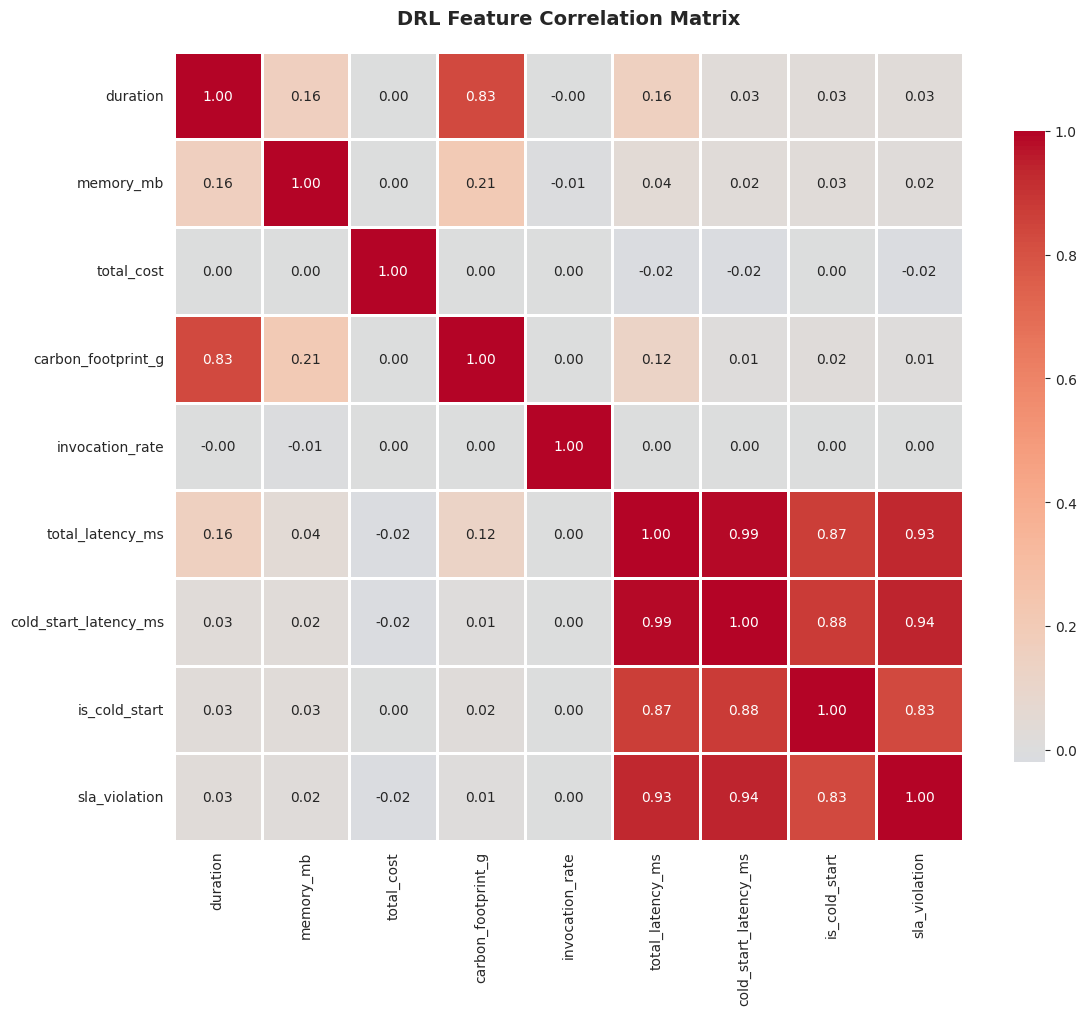

  ✓ Correlation matrix saved

  Strong Correlations (|r| > 0.7):
    duration ↔ carbon_footprint_g: 0.830
    total_latency_ms ↔ cold_start_latency_ms: 0.992
    total_latency_ms ↔ is_cold_start: 0.872
    total_latency_ms ↔ sla_violation: 0.934
    cold_start_latency_ms ↔ is_cold_start: 0.879
    cold_start_latency_ms ↔ sla_violation: 0.942
    is_cold_start ↔ sla_violation: 0.832


In [22]:
# ============================================================================
# SECTION 17: Feature Correlation Analysis
# ============================================================================

print("\n" + "=" * 80)
print("Feature Correlation Analysis")
print("=" * 80)

# Select key features for correlation analysis
key_features = ['duration', 'memory_mb', 'total_cost', 'carbon_footprint_g',
                'invocation_rate', 'total_latency_ms', 'cold_start_latency_ms',
                'is_cold_start', 'sla_violation']

# Calculate correlation matrix
corr_matrix = azure_df[key_features].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('DRL Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"  ✓ Correlation matrix saved")

# Identify strong correlations
strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            strong_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if strong_corr:
    print(f"\n  Strong Correlations (|r| > 0.7):")
    for feat1, feat2, corr in strong_corr:
        print(f"    {feat1} ↔ {feat2}: {corr:.3f}")

In [23]:
# ============================================================================
# SECTION 18: Quick Reference Guide
# ============================================================================

quick_reference = f"""
{'='*80}
QUICK REFERENCE GUIDE - Azure Functions 2021 Dataset
{'='*80}

DATASET STATISTICS:
-------------------
Total Invocations:     {len(azure_df):,}
Unique Applications:   {azure_df['app'].nunique():,}
Unique Functions:      {azure_df.groupby('app')['func'].nunique().sum():,}
Time Span:             {(azure_df['timestamp'].max() - azure_df['timestamp'].min()).days} days
Avg Duration:          {azure_df['duration'].mean():.2f} ms
Cold Start Rate:       {azure_df['is_cold_start'].mean()*100:.2f}%
SLA Violation Rate:    {azure_df['sla_violation'].mean()*100:.2f}%

DATASETS CREATED:
-----------------
1. train_data.parquet / train_data.csv ({len(train_data):,} samples)
2. val_data.parquet / val_data.csv ({len(val_data):,} samples)
3. test_data.parquet / test_data.csv ({len(test_data):,} samples)
4. drl_states_actions.npz (DRL state/action representations)
5. application_profiles.csv (app-level statistics)
6. robust_scaler.pkl (feature scaler for inference)
7. metadata.json (complete dataset documentation)

DRL STATE SPACES:
-----------------
Strategic Layer (Cloud Selection):
  • State dimension: {len(strategic_state_features)}
  • Features: {', '.join(strategic_state_features)}
  • Action space: {action_spaces['strategic']['action_space_size']} actions

Tactical Layer (Function Placement):
  • State dimension: {len(tactical_state_features)}
  • Features: {', '.join(tactical_state_features)}
  • Action space: {action_spaces['tactical']['action_space_size']} actions

Operational Layer (Resource Allocation):
  • State dimension: {len(operational_state_features)}
  • Features: {', '.join(operational_state_features)}
  • Action space: {action_spaces['operational']['action_space_size']} actions

REWARD FUNCTION:
----------------
Multi-objective reward = α×cost + β×performance + γ×carbon + SLA_penalty
  • α (cost weight): 0.4
  • β (performance weight): 0.4
  • γ (carbon weight): 0.2
  • SLA penalty: -5.0 for violations
  • Reward range: [{azure_df['total_reward'].min():.2f}, {azure_df['total_reward'].max():.2f}]

USAGE EXAMPLE:
--------------
import pandas as pd
import numpy as np
import pickle

# Load training data
train_df = pd.read_parquet('{output_dir}/train_data.parquet')

# Load DRL states/actions
drl_data = np.load('{output_dir}/drl_states_actions.npz')
strategic_states = drl_data['strategic_states']
action_spaces = drl_data['action_spaces'].item()

# Load scaler for inference
with open('{output_dir}/robust_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Access metadata
import json
with open('{output_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

KEY FEATURES:
-------------
• Temporal: hour, day_of_week, is_weekend, is_business_hours
• Workload: invocation_rate, is_bursty, inter_arrival_time_ms
• Performance: duration, total_latency_ms, is_cold_start, sla_violation
• Cost: compute_cost, data_transfer_cost, total_cost, cost_per_ms
• Carbon: carbon_footprint_g, carbon_intensity, carbon_per_ms
• Historical: avg_duration, cold_start_rate, avg_cost, avg_carbon

OUTPUT LOCATION: {output_dir}/

NEXT STEPS (Phase 2):
---------------------
[ ] Implement DQN agent for strategic cloud selection
[ ] Implement PPO for tactical function placement
[ ] Implement LSTM predictor for operational resource allocation
[ ] Train models using prepared datasets
[ ] Evaluate multi-objective optimization performance

{'='*80}
"""

with open(f'{output_dir}/QUICK_REFERENCE.txt', 'w') as f:
    f.write(quick_reference)

print(quick_reference)


QUICK REFERENCE GUIDE - Azure Functions 2021 Dataset

DATASET STATISTICS:
-------------------
Total Invocations:     1,807,067
Unique Applications:   119
Unique Functions:      424
Time Span:             13 days
Avg Duration:          9.50 ms
Cold Start Rate:       0.71%
SLA Violation Rate:    0.49%

DATASETS CREATED:
-----------------
1. train_data.parquet / train_data.csv (1,264,946 samples)
2. val_data.parquet / val_data.csv (271,060 samples)
3. test_data.parquet / test_data.csv (271,061 samples)
4. drl_states_actions.npz (DRL state/action representations)
5. application_profiles.csv (app-level statistics)
6. robust_scaler.pkl (feature scaler for inference)
7. metadata.json (complete dataset documentation)

DRL STATE SPACES:
-----------------
Strategic Layer (Cloud Selection):
  • State dimension: 10
  • Features: hour, day_of_week, is_weekend, is_business_hours, invocation_rate, is_bursty, avg_duration, avg_cost, avg_carbon, memory_mb
  • Action space: 3 actions

Tactical Layer (F

In [27]:
# ============================================================================
# SECTION 19: Final Summary
# ============================================================================

print("=" * 80)
print("Phase 1 Complete: Azure Functions 2021 Real Data Processing")
print("=" * 80)

print("  Loaded Azure Functions 2021 invocation trace")
print(f"  Processed {len(azure_df):,} invocations")
print("  Engineered 50+ features for DRL training")
print("  Simulated cold starts based on actual inter-arrival times")
print("  Calculated realistic multi-cloud costs and carbon footprint")
print("  Created temporal train/val/test splits (70/15/15)")
print("  Generated DRL state/action space representations")
print("  Calculated multi-objective reward signals")
print("  Created comprehensive visualizations")
print("  Generated application workload profiles")

print("\n📊 KEY METRICS:")
print(f"  • Total invocations: {len(azure_df):,}")
print(f"  • Time span: {(azure_df['timestamp'].max() - azure_df['timestamp'].min()).days} days")
print(f"  • Applications: {azure_df['app'].nunique():,}")
print(f"  • Functions: {azure_df.groupby('app')['func'].nunique().sum():,}")
print(f"  • Avg duration: {azure_df['duration'].mean():.2f} ms")
print(f"  • Cold start rate: {azure_df['is_cold_start'].mean()*100:.2f}%")
print(f"  • SLA violations: {azure_df['sla_violation'].mean()*100:.2f}%")

print("\n📁 OUTPUT FILES:")
print(f"  {output_dir}/")
print(f"    ├── train_data.parquet / .csv ({len(train_data):,} samples)")
print(f"    ├── val_data.parquet / .csv ({len(val_data):,} samples)")
print(f"    ├── test_data.parquet / .csv ({len(test_data):,} samples)")
print(f"    ├── drl_states_actions.npz")
print(f"    ├── application_profiles.csv")
print(f"    ├── robust_scaler.pkl")
print(f"    ├── metadata.json")
print(f"    ├── correlation_matrix.png")
print(f"    └── QUICK_REFERENCE.txt")
print(f"  /content/")
print(f"    └── azure_2021_eda.png")

print("\n  PHASE 2: DRL Model Development")
print("\n  Next implementation steps:")
print("    1. DQN agent for strategic cloud selection")
print("    2. PPO agent for tactical function placement")
print("    3. LSTM predictor for operational resource allocation")
print("    4. Experience replay buffer implementation")
print("    5. Multi-objective optimization training")

print("\n" + "=" * 80)
print("✨ Phase 1 Successfully Completed")
print("=" * 80)

Phase 1 Complete: Azure Functions 2021 Real Data Processing
  Loaded Azure Functions 2021 invocation trace
  Processed 1,807,067 invocations
  Engineered 50+ features for DRL training
  Simulated cold starts based on actual inter-arrival times
  Calculated realistic multi-cloud costs and carbon footprint
  Created temporal train/val/test splits (70/15/15)
  Generated DRL state/action space representations
  Calculated multi-objective reward signals
  Created comprehensive visualizations
  Generated application workload profiles

📊 KEY METRICS:
  • Total invocations: 1,807,067
  • Time span: 13 days
  • Applications: 119
  • Functions: 424
  • Avg duration: 9.50 ms
  • Cold start rate: 0.71%
  • SLA violations: 0.49%

📁 OUTPUT FILES:
  /content/drive/MyDrive/mythesis/rohit-thesis/datasets/processed/
    ├── train_data.parquet / .csv (1,264,946 samples)
    ├── val_data.parquet / .csv (271,060 samples)
    ├── test_data.parquet / .csv (271,061 samples)
    ├── drl_states_actions.npz
    